In [53]:
import json
import re
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
raw_data = []

# Open the JSON file and read it line by line
with open('/content/drive/My Drive/Dataset/NLP_resume_Extraction/Resume.json','r') as f:
    for line in f:
        # Parse each line as JSON and append it to the data list
        raw_data.append(json.loads(line))

In [5]:
# raw_data=[]
# with open('/kaggle/input/resume-enitity-ner/Resume.json','r') as f:
#     for line in f:
#         # Parse each line as JSON and append it to the data list
#         raw_data.append(json.loads(line))

In [6]:
raw_data[1]

{'content': "Harini Komaravelli\nTest Analyst at Oracle, Hyderabad\n\nHyderabad, Telangana - Email me on Indeed: indeed.com/r/Harini-\nKomaravelli/2659eee82e435d1b\n\n➢ 6 Yrs. of IT Experience in Manual and Automation testing.\n\nWORK EXPERIENCE\n\nQA Analyst\n\nOracle\n\nTest Analyst at Oracle, Hyderabad\n\nInfosys Ltd -  Hyderabad, Telangana -\n\nNovember 2011 to February 2016\n\nHyderabad from Nov 2011 to Feb17 2016\n➢ Worked in Tata Consultancy Services, Hyderabad from Feb 24 to Apr 11 2017\n➢ Currently working as a Test Analyst at Oracle, Hyderabad\n\nQA Analyst with 6 years of IT experience\n\nOracle\n\nEDUCATION\n\nMCA\n\nOsmania University\n\nB.Sc. in Computer Science\n\nOsmania University\n\nSKILLS\n\nFunctional Testing, Blue Prism, Qtp\n\nADDITIONAL INFORMATION\n\nArea of Expertise:\n\n➢ Familiar with Agile Methodologies.\n➢ Having knowledge in Energy (Petroleum) & Health Care domains.\n➢ Involved in preparation of Test Scenarios.\n➢ Preparing Test Data for the test cases.\n\

In [7]:
import re

def remove_punctuation(text):
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

In [8]:
import json

def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    lines=[]
    with open(dataturks_JSON_FilePath, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = json.loads(line)
        text = data['content'].replace("\n", " ")
        entities = []
        data_annotations = data['annotation']
        if data_annotations is not None:
            for annotation in data_annotations:
                # only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    point_start = point['start']
                    point_end = point['end']
                    point_text = point['text']

                    lstrip_diff = len(point_text) - len(point_text.lstrip())
                    rstrip_diff = len(point_text) - len(point_text.rstrip())
                    if lstrip_diff != 0:
                        point_start = point_start + lstrip_diff
                    if rstrip_diff != 0:
                        point_end = point_end - rstrip_diff
                    print((point_start, point_end + 1 , label,point_text))
                    entities.append((point_start, point_end + 1 , label))
        training_data.append((text, {"entities" : entities}))
    return training_data

In [9]:
def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')
    span_entities=[]
    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end

            # Ensure valid_start and valid_end are within bounds
            if valid_start < 0:
                valid_start = 0
            if valid_end > len(text):
                valid_end = len(text)

            while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
                valid_end -= 1

            if valid_start < valid_end:  # Ensure valid spans
                valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
        span_entities.append(valid_entities)
    return cleaned_data,span_entities


In [10]:
data = convert_dataturks_to_spacy("/content/drive/My Drive/Dataset/NLP_resume_Extraction/Resume.json")

(1749, 1755, 'Companies worked at', 'Oracle')
(1696, 1702, 'Companies worked at', 'Oracle')
(1417, 1423, 'Companies worked at', 'Oracle')
(1356, 1793, 'Skills', 'Languages: Core Java, Go Lang, Data Structures & Algorithms, Oracle\nPL-SQL programming, Sales Force with APEX.\nTools: RADTool, Jdeveloper, NetBeans, Eclipse, SQL developer,\nPL/SQL Developer, WinSCP, Putty\nWeb Technologies: JavaScript, XML, HTML, Webservice\n\nOperating Systems: Linux, Windows\nVersion control system SVN & Git-Hub\nDatabases: Oracle\nMiddleware: Web logic, OC4J\nProduct FLEXCUBE: Oracle FLEXCUBE Versions 10.x, 11.x and 12.x')
(1209, 1215, 'Companies worked at', 'Oracle')
(1136, 1247, 'Skills', 'APEX. (Less than 1 year), Data Structures (3 years), FLEXCUBE (5 years), Oracle (5 years),\nAlgorithms (3 years)\n')
(928, 932, 'Graduation Year', '2012')
(858, 889, 'College Name', 'Adithya Institute of Technology')
(821, 856, 'Degree', 'B.E in Computer Science Engineering')
(787, 791, 'Graduation Year', '2012')
(74

In [11]:
converted_data,valid_entities = trim_entity_spans(data)

In [21]:
def find_overlapping_entities(data):
    overlapping_entities = []
    for text, annotations in data:
        entities = annotations['entities']
        entities = sorted(entities, key=lambda x: x[0])  # Sort entities by start position
        for i in range(len(entities) - 1):
            start1, end1, label1 = entities[i]
            start2, end2, label2 = entities[i + 1]
            if start2 < end1:  # Check for overlap
                overlapping_entities.append(((start1, end1, label1), (start2, end2, label2)))
    return overlapping_entities

In [22]:

data = converted_data
overlapping_entities = find_overlapping_entities(data)

if overlapping_entities:
    print("Overlapping entities found:")
    for ent1, ent2 in overlapping_entities:
        print(f"Overlap between {ent1} and {ent2}")
else:
    print("No overlapping entities found.")


Overlapping entities found:
Overlap between (1136, 1247, 'Skills') and (1209, 1215, 'Companies worked at')
Overlap between (1356, 1793, 'Skills') and (1417, 1423, 'Companies worked at')
Overlap between (34, 49, 'Companies worked at') and (34, 49, 'Companies worked at')
Overlap between (4121, 4399, 'Skills') and (4186, 4191, 'Companies worked at')
Overlap between (2116, 2143, 'College Name') and (2128, 2143, 'Companies worked at')
Overlap between (886, 897, 'Skills') and (894, 897, 'Skills')
Overlap between (1106, 1183, 'Degree') and (1153, 1183, 'College Name')
Overlap between (1734, 1745, 'Skills') and (1742, 1745, 'Skills')
Overlap between (1748, 1790, 'Skills') and (1765, 1771, 'Skills')
Overlap between (1794, 1830, 'Skills') and (1811, 1815, 'Skills')
Overlap between (1844, 1873, 'Skills') and (1844, 1860, 'Skills')
Overlap between (3466, 3819, 'Skills') and (3535, 3541, 'Companies worked at')
Overlap between (6305, 7258, 'Skills') and (6861, 6870, 'Companies worked at')
Overlap be

In [23]:
def correct_annotations(data):
    corrected_data = []
    for text, annotations in data:
        entities = annotations['entities']
        entities = sorted(entities, key=lambda x: x[0])  # Sort entities by start position
        corrected_entities = []

        i = 0
        while i < len(entities):
            start1, end1, label1 = entities[i]
            if i + 1 < len(entities):
                start2, end2, label2 = entities[i + 1]
                if start2 < end1:  # Check for overlap
                    # Resolve overlap by adjusting the end position of the first entity
                    end1 = start2 - 1  # Adjust end position of the first entity
                    if end1 >= start1:  # Append the corrected entity if valid
                        corrected_entities.append((start1, end1, label1))
                else:
                    corrected_entities.append((start1, end1, label1))
            else:
                corrected_entities.append((start1, end1, label1))
            i += 1

        corrected_data.append((text, {"entities": corrected_entities}))

    return corrected_data


In [24]:
corrected_data = correct_annotations(converted_data)

In [25]:
data = corrected_data
overlapping_entities = find_overlapping_entities(data)

if overlapping_entities:
    print("Overlapping entities found:")
    for ent1, ent2 in overlapping_entities:
        print(f"Overlap between {ent1} and {ent2}")
else:
    print("No overlapping entities found.")


No overlapping entities found.


In [26]:
import random
import math

def train_test_split(data, test_size, random_state):

    random.Random(random_state).shuffle(data)
    test_idx = len(data) - math.floor(test_size * len(data))
    train_set = data[0: test_idx]
    test_set = data[test_idx: ]

    return train_set, test_set

In [27]:
train_data, test_data = train_test_split(corrected_data, test_size = 0.1, random_state = 42)

In [89]:
test_data[6]

("Ashish Indoriya Sr. Systems Engineer at Infosys Limited  Hyderabad, Telangana - Email me on Indeed: indeed.com/r/Ashish- Indoriya/84f99c99ebe940be  • Master of Computer Application (MCA) from Bhilai Institute of Technology, Durg, 2014. • Having 3.3 years of Experience on Software Development at Infosys limited. • Extensive working experience on Java, Spring, Hibernate and SQL • Knowledge of design patterns such as Singleton, Factory, Façade, Observer and MVC. • Knowledge of Front-end web development using JavaScript, JQuery, CSS &amp; HTML. • Having knowledge of Oracle SQL Database. • Reliable as a fully contributing, responsible and accountable member of task/ project teams with highly honed creative, logical and analytical approach. • Automated some of HRMS processes like Hiring, transfer, termination to help speed up the QA process. • Hands on knowledge of C, C++ including advanced concepts such as pointers and Dynamic Memory Management. • Learning Hadoop and Big data analysis usi

In [18]:
import spacy

In [19]:
from spacy.tokens import Span

In [29]:
import spacy
from spacy.training import Example

def train_spacy(data, iterations=30):
    nlp = spacy.blank("en")  # create a blank Language class
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # Initialize the optimizer
    optimizer = nlp.begin_training()

    for itn in range(iterations):
        print("Starting iteration " + str(itn))
        random.shuffle(data)
        losses = {}
        for text, annotations in data:
            #print('Text.@@ ',text)
            #print('annotations@@: ', annotations)

            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.5, losses=losses, sgd=optimizer)
        print(losses)
    return nlp

#Save the model
nlp_1 = train_spacy(corrected_data)


Starting iteration 0
{'ner': 14029.975194453633}
Starting iteration 1
{'ner': 6639.190742533247}
Starting iteration 2
{'ner': 6028.416990788694}
Starting iteration 3
{'ner': 6590.487438889571}
Starting iteration 4
{'ner': 4833.371942201854}
Starting iteration 5
{'ner': 4954.524590156276}
Starting iteration 6
{'ner': 4491.915086000879}
Starting iteration 7
{'ner': 4633.543577750083}
Starting iteration 8
{'ner': 4733.7643600896645}
Starting iteration 9
{'ner': 4103.755733284022}
Starting iteration 10
{'ner': 3903.8968605339983}
Starting iteration 11
{'ner': 3579.346407024464}
Starting iteration 12
{'ner': 3541.589292198706}
Starting iteration 13
{'ner': 3617.450680274071}
Starting iteration 14
{'ner': 3386.443179580568}
Starting iteration 15
{'ner': 3218.5989962421204}
Starting iteration 16
{'ner': 3369.0611261215518}
Starting iteration 17
{'ner': 3347.0347932743193}
Starting iteration 18
{'ner': 3392.3511156718146}
Starting iteration 19
{'ner': 3010.582689805922}
Starting iteration 20
{

In [30]:
nlp_1.to_disk('/content/drive/My Drive/Dataset/NLP_resume_Extraction/ner_model_spacy_resumse_parsor')

In [31]:
model = spacy.load('/content/drive/My Drive/Dataset/NLP_resume_Extraction/ner_model_spacy_resumse_parsor')

In [78]:
test_sample = """Sharan

AI / Machine Learning

Delhi, India Email me on Indeed
•
20+ years of experience in data handling, design, and development
•
Data Warehouse: Data analysis, star/snow flake scema data modelling and design specific to
data warehousing and business intelligence
•
Database: Experience in database designing, scalability, back-up and recovery, writing and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes.
Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure,
Stream Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake
analytics(U-SQL)
Willing to relocate anywhere

WORK EXPERIENCE
Software Engineer
Microsoft – Bangalore, Karnataka
January 2000 to Present
1. Microsoft Rewards Live dashboards:
Description: - Microsoft rewards is loyalty program that rewards Users for browsing and shopping
online. Microsoft Rewards members can earn points when searching with Bing, browsing with
Microsoft Edge and making purchases at the Xbox Store, the Windows Store and the Microsoft
Store. Plus, user can pick up bonus points for taking daily quizzes and tours on the Microsoft
rewards website. Rewards live dashboards gives a live picture of usage world-wide and by
markets like US, Canada, Australia, new user registration count, top/bottom performing rewards
offers, orders stats and weekly trends of user activities, orders and new user registrations. the
PBI tiles gets refreshed in different frequencies starting from 5 seconds to 30 minutes.
Technology/Tools used

EDUCATION
Indian Institute of Technology – Mumbai
2001

SKILLS
Machine Learning, Natural Language Processing, and Big Data Handling

ADDITIONAL INFORMATION
Professional Skills
• Excellent analytical, problem solving, communication, knowledge transfer and interpersonal
skills with ability to interact with individuals at all the levels
• Quick learner and maintains cordial relationship with project manager and team members and
good performer both in team and independent job environments
• Positive attitude towards superiors &amp; peers
• Supervised junior developers throughout project lifecycle and provided technical assistance """

In [80]:
# test model
test_document = model(" ".join(test_sample.split('\n')))
for ent in test_document.ents:
    ent_label = ent.label_
    print(f"\033[1m{ent_label}\033[0m")
    print(ent.text, ': ',ent.start_char, ent.end_char)

Name
Sharan    :  0 9
Location
Delhi :  33 38
Companies worked at
Microsoft :  480 489
Designation
Software Engineer Microsoft :  686 713
Companies worked at
Microsoft :  764 773
Companies worked at
Microsoft :  814 823
Companies worked at
Microsoft :  904 913
Companies worked at
Microsoft :  986 995
Companies worked at
Microsoft :  1067 1076
Companies worked at
Microsoft :  1162 1171
College Name
Indian Institute of Technology :  1576 1606


In [90]:
test_sentence_2 ="""Pratibha P

SOFTWARE ENGINEER

CONTACT
cmcturland@indeed.com
(123) 456-7890
Chennai, India

EDUCATION
B.S.Computer Science
University of Pittsburgh
September 2008 - April 2012
Kochin, Kerela

SKILLS
Python (Django)
Javascript (NodeJS ReactJS,
jQuery)
SQL (MySQL, PostgreSQL,
NoSQL)
HTML5/CSS
AWS
Unix, Git

WORK EXPERIENCE
Software Engineer

January 2015 - current / Delhi, India
Worked with product managers to re-architect a multi-page web
app into a single page web-app, boosting yearly revenue by $1.4M
Constructed the logic for a streamlined ad-serving platform that
scaled to our 35M users, which improved the page speed by 15%
after implementation
Tested software for bugs and operating speed, fixing bugs and
documenting processes to increase efficiency by 18%
Iterated platform for college admissions, collaborating with a group
of 4 engineers to create features across the software

MarketSmart
Software Engineer

April 2012 - January 2015 / Delhi, India
Built RESTful APIs that served data to the JavaScript front-end
based on dynamically chosen user inputs that handled over 500,000
concurrent users
Built internal tool using NodeJS and Pupeteer.js to automate QA and
monitoring of donor-facing web app, which improved CTR by 3%
Reviewed code and conducted testing for 3 additional features on
donor-facing web app that increased contributions by 12%
Software Engineer Intern
Marketing ScienceCompany
April 2011 - March 2012 / Pittsburgh, PA
Partnered with a developer to implement RESTful APIs in Django,
enabling analytics team to increase reporting speed by 24%
Using Selenium I built out a unit testing infrastructure for a client
application that reduced the number of bugs reported by the client
by 11% month over month

PROJECTS
Poker Simulation
Built a full-stack web app to allow users to simulate and visualize
outcomes of poker hands against opponents of different play styles
using open source cards.js on the front-end
Utilized sci-kit learn in Python to simulate possible outcomes under
different scenarios that the user chose
"""

In [91]:
# test model
test_document = model(" ".join(test_sentence_2.split('\n')))
for ent in test_document.ents:
    ent_label = ent.label_
    print(f"\033[1m{ent_label}\033[0m")
    print(ent.text, ': ',ent.start_char, ent.end_char)

Name
Pratibha P :  0 10
Designation
SOFTWARE ENGINEER :  12 29
College Name
Science University of Pittsburgh :  115 147
Skills
Python (Django) Javascript (NodeJS ReactJS, jQuery) SQL (MySQL, PostgreSQL, NoSQL) HTML5/CSS AWS Unix, Git  WORK :  200 312
Designation
Software Engineer :  324 341


In [34]:
print(spacy.__version__)

3.7.5


In [35]:
import spacy
from spacy.training.example import Example


examples = []
data = test_data
for text, annots in data:
    doc = model.make_doc(text)
    examples.append(Example.from_dict(doc, annots))
print(model.evaluate(examples)) # This will provide overall and per entity metrics


{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8208955223880597, 'ents_r': 0.7719298245614035, 'ents_f': 0.7956600361663653, 'ents_per_type': {'Name': {'p': 1.0, 'r': 1.0, 'f': 1.0}, 'Email Address': {'p': 1.0, 'r': 0.9411764705882353, 'f': 0.9696969696969697}, 'Years of Experience': {'p': 0.6666666666666666, 'r': 0.4, 'f': 0.5}, 'Designation': {'p': 0.9512195121951219, 'r': 0.75, 'f': 0.8387096774193549}, 'Degree': {'p': 0.9130434782608695, 'r': 1.0, 'f': 0.9545454545454545}, 'College Name': {'p': 0.9629629629629629, 'r': 0.9285714285714286, 'f': 0.9454545454545454}, 'Companies worked at': {'p': 0.6875, 'r': 0.8333333333333334, 'f': 0.7534246575342466}, 'Location': {'p': 0.88, 'r': 0.6470588235294118, 'f': 0.7457627118644068}, 'Skills': {'p': 0.6, 'r': 0.4090909090909091, 'f': 0.4864864864864865}, 'Graduation Year': {'p': 0.5555555555555556, 'r': 0.5, 'f': 0.5263157894736842}}, 'speed': 15765.073096534534}


In [54]:
evaluation_metric = model.evaluate(examples)

# Extract the 'ents_per_type' dictionary
ents_per_type = evaluation_metric['ents_per_type']

# Convert the dictionary to a DataFrame
data = []
for entity, metrics in ents_per_type.items():
    data.append({
        'Entity': entity,
        'Precision': metrics['p'],
        'Recall': metrics['r'],
        'F1 Score': metrics['f']
    })

df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                Entity  Precision    Recall  F1 Score
0                 Name   1.000000  1.000000  1.000000
1        Email Address   1.000000  0.941176  0.969697
2  Years of Experience   0.666667  0.400000  0.500000
3          Designation   0.951220  0.750000  0.838710
4               Degree   0.913043  1.000000  0.954545
5         College Name   0.962963  0.928571  0.945455
6  Companies worked at   0.687500  0.833333  0.753425
7             Location   0.880000  0.647059  0.745763
8               Skills   0.600000  0.409091  0.486486
9      Graduation Year   0.555556  0.500000  0.526316


In [55]:
eval_results = model.evaluate(examples)

# Extract true and predicted labels for each token
true_labels = []
pred_labels = []

for example in examples:
    doc = example.reference
    pred_doc = model(example.text)

    for token in doc:
        true_labels.append(token.ent_type_ if token.ent_type_ else "O")

    for token in pred_doc:
        pred_labels.append(token.ent_type_ if token.ent_type_ else "O")

# Ensure both lists have the same length
assert len(true_labels) == len(pred_labels), "Mismatch between true and predicted labels length"

# Generate the confusion matrix
labels = list(model.get_pipe("ner").labels) + ["O"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
report = classification_report(true_labels, pred_labels, labels=labels, target_names=labels)

# Create a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Print the confusion matrix and classification report
print("Confusion Matrix:\n", cm_df)


Confusion Matrix:
                      College Name  Companies worked at  Degree  Designation  \
College Name                  102                    0       0            0   
Companies worked at             0                   98       0            0   
Degree                          0                    0      57            0   
Designation                     0                    2       0          112   
Email Address                   0                    0       0            0   
Graduation Year                 0                    0       0            0   
Location                        0                    0       0            0   
Name                            0                    0       0            0   
Skills                          0                    1       0            0   
UNKNOWN                         0                    0       0            0   
Years of Experience             0                    0       0            0   
O                              14

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [56]:
print("\nClassification Report:\n", report)


Classification Report:
                      precision    recall  f1-score   support

       College Name       0.88      0.96      0.92       106
Companies worked at       0.58      0.89      0.71       110
             Degree       0.58      1.00      0.74        57
        Designation       0.46      0.80      0.58       140
      Email Address       1.00      0.87      0.93        23
    Graduation Year       0.56      0.50      0.53        20
           Location       0.93      0.68      0.78        37
               Name       1.00      1.00      1.00        40
             Skills       0.94      0.56      0.70      1260
            UNKNOWN       0.00      0.00      0.00         0
Years of Experience       1.00      0.55      0.71        11
                  O       0.94      0.97      0.96     10312

          micro avg       0.92      0.92      0.92     12116
          macro avg       0.74      0.73      0.71     12116
       weighted avg       0.93      0.92      0.92     121

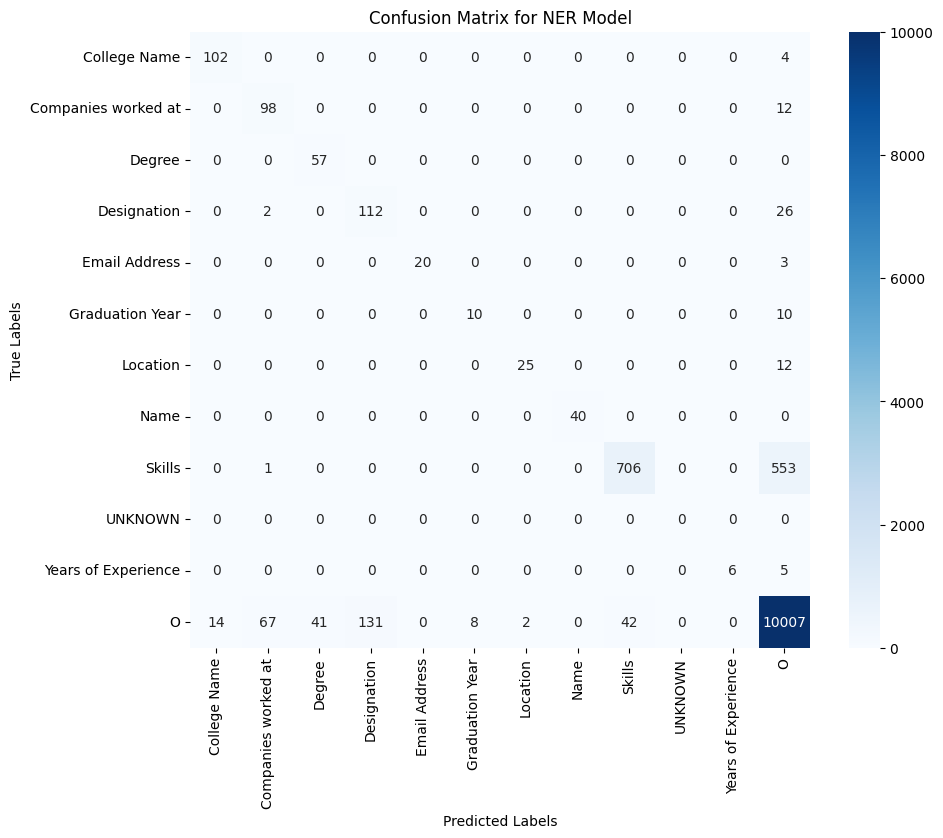

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for NER Model')
plt.show()

# Print the classification report
report = classification_report(true_labels, pred_labels, labels=labels, target_names=labels)
#print("\nClassification Report:\n", report)